# **Bildklassifikation der Simpsons-Charaktere mit Neuronalen Netzen**

**Name:** Justin Stange-Heiduk  
**Matrikelnummer:** [Deine Matrikelnummer]  
**Universität:** AKAD   
**Kurs:** B.Sc Data Science     
**Dozent:** Dr. Martin Prause   
**Beginn:** 03.02.2025  
**Orientiert an:** https://www.kaggle.com/code/serkan0yldz/cnn-classification-for-simpsons-characters-dataset

---


## Importe

In [12]:

import os
import pandas as pd
from tqdm import tqdm  # Fortschrittsbalken für Schleifen
import kaggle
from collections import Counter
import random
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image  # Pillow für Bildmanipulation
import numpy as np

## Datenset herunterladen

In [ ]:
kaggle_dataset = "alexattia/the-simpsons-characters-dataset"
download_path = "./simpsons_dataset"

os.makedirs(download_path, exist_ok=True)

# Lade das Dataset herunter
kaggle.api.dataset_download_files(kaggle_dataset, path=download_path, unzip=True)

print("✅ Dataset erfolgreich heruntergeladen und entpackt.")

In [2]:
# Setze den Pfad zum ursprünglichen Dataset
original_dataset_path = "./simpsons_dataset/simpsons_dataset"


In [ ]:
# Liste die ersten paar Dateien und Ordner auf
print("Inhalt des Dataset-Ordners:")
print(os.listdir(download_path)[:6])  # Zeige die Elemente

Inhalt des Dataset-Ordners:
['annotation.txt', 'characters_illustration.png', 'kaggle_simpson_testset', 'number_pic_char.csv', 'simpsons_dataset', 'the-simpsons-characters-dataset.zip']


## Datenexploration
### Überprüfen der Verzeichnisstruktur

In [13]:
# Setze den Pfad zum entpackten Dataset
dataset_path = "./simpsons_dataset/simpsons_dataset"

# Prüfe, ob der Pfad existiert
if not os.path.exists(dataset_path):
    print("❌ Fehler: Der Dataset-Pfad existiert nicht. Überprüfe den Download.")
else:
    # Liste alle Unterverzeichnisse (Charaktere) auf
    characters = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    
    print(f"✅ Anzahl der Charaktere im Dataset: {len(characters)}")
    print("🔍 Alle Charaktere:", characters)  # Zeige alle verfügbaren Charaktere

✅ Anzahl der Charaktere im Dataset: 42
🔍 Alle Charaktere: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


### Anzahl der Bilder pro Charakter zählen

In [14]:
# Zähle die Anzahl der Bilder pro Charakter
character_image_counts = {character: len(os.listdir(os.path.join(dataset_path, character))) for character in characters}

# In einen DataFrame umwandeln
df_character_counts = pd.DataFrame(list(character_image_counts.items()), columns=["Character", "Image Count"])
df_character_counts = df_character_counts.sort_values(by="Image Count", ascending=False)

# DataFrame anzeigen
(df_character_counts)

,Character,Image Count
15,homer_simpson,2246
28,ned_flanders,1454
27,moe_szyslak,1452
20,lisa_simpson,1354
4,bart_simpson,1342
22,marge_simpson,1291
17,krusty_the_clown,1206
32,principal_skinner,1194
6,charles_montgomery_burns,1193
25,milhouse_van_houten,1079


Das verwendete Simpsons_Dataset enthält eine unterschiedlich hohe Anzahl an Bildern für die verschiedenen Charaktere. Eine Analyse der Daten hat gezeigt, dass einige Charaktere mit mehreren tausend Bildern vertreten sind, während andere nur wenige Dutzend Bilder aufweisen. Diese unausgeglichene Klassenverteilung kann sich negativ auf das Training eines neuronalen Netzes auswirken, da das Modell dazu tendiert, Klassen mit vielen Bildern bevorzugt zu lernen, während Klassen mit wenigen Bildern schlechter erkannt werden.

Mögliche Maßnahmen zur Ausbalancierung der Daten
Um dieses Problem in einem produktiven Einsatz zu adressieren, könnte man verschiedene Techniken anwenden:

Oversampling: Erhöhung der Anzahl seltener Klassen durch Duplizieren bestehender oder synthetisch erzeugter Bilder (z. B. mit SMOTE für Bilder).  

Undersampling: Reduzierung der Anzahl häufiger Klassen, um ein ausgeglicheneres Verhältnis zu erhalten.

Datenaugmentierung: Künstliche Erweiterung der Bilddaten durch Transformationen wie Rotation, Skalierung, Spiegelung oder Farbveränderungen, um die Variabilität der Daten zu erhöhen.  

**Verzicht auf Balancing in diesem Proof of Concept (PoC)**

Da diese Arbeit lediglich einen Proof of Concept (PoC) darstellt, werden Klassen mit weniger als 500 Bilder entfernt. Das Hauptziel ist es, eine funktionierende Bildklassifikation auf Basis neuronaler Netze zu demonstrieren und den Prozess der Modellentwicklung mit MLflow zu dokumentieren. In einer realen Anwendung wäre es jedoch essenziell, geeignete Maßnahmen zur Datenbalancierung zu ergreifen, um die Modellqualität und die Vorhersagegenauigkeit insbesondere für unterrepräsentierte Klassen zu verbessern.

In [18]:
# Mindestanzahl an Bildern setzen
min_images = 500

filtered_dataset_path = "./filtered_simpsons_dataset"

# Neues Dataset-Verzeichnis erstellen
os.makedirs(filtered_dataset_path, exist_ok=True)

# Charaktere mit mehr als 200 Bildern behalten
filtered_characters = [char for char, count in character_image_counts.items() if count >= min_images]

# Charaktere durchgehen
for character in os.listdir(dataset_path):
    character_path = os.path.join(dataset_path, character)

    if os.path.isdir(character_path):
        if character in filtered_characters:
            # Neuen Pfad für gefilterte Daten erstellen
            new_path = os.path.join(filtered_dataset_path, character)
            os.makedirs(new_path, exist_ok=True)

            # Kopiere Bilder in das neue Dataset
            for img in os.listdir(character_path):
                if img.endswith((".jpg", ".png")):
                    shutil.copy(os.path.join(character_path, img), os.path.join(new_path, img))
            print(f"✅ Behalten: {character} ({character_image_counts[character]} Bilder)")
        else:
            print(f"❌ Entfernt: {character} ({character_image_counts.get(character, 0)} Bilder)")

print(f"📂 Neues gefiltertes Dataset gespeichert unter: {filtered_dataset_path}")


✅ Behalten: abraham_grampa_simpson (913 Bilder)
❌ Entfernt: agnes_skinner (42 Bilder)
✅ Behalten: apu_nahasapeemapetilon (623 Bilder)
❌ Entfernt: barney_gumble (106 Bilder)
✅ Behalten: bart_simpson (1342 Bilder)
❌ Entfernt: carl_carlson (98 Bilder)
✅ Behalten: charles_montgomery_burns (1193 Bilder)
✅ Behalten: chief_wiggum (986 Bilder)
❌ Entfernt: cletus_spuckler (47 Bilder)
❌ Entfernt: comic_book_guy (469 Bilder)
❌ Entfernt: disco_stu (8 Bilder)
❌ Entfernt: edna_krabappel (457 Bilder)
❌ Entfernt: fat_tony (27 Bilder)
❌ Entfernt: gil (27 Bilder)
❌ Entfernt: groundskeeper_willie (121 Bilder)
✅ Behalten: homer_simpson (2246 Bilder)
❌ Entfernt: kent_brockman (498 Bilder)
✅ Behalten: krusty_the_clown (1206 Bilder)
❌ Entfernt: lenny_leonard (310 Bilder)
❌ Entfernt: lionel_hutz (3 Bilder)
✅ Behalten: lisa_simpson (1354 Bilder)
❌ Entfernt: maggie_simpson (128 Bilder)
✅ Behalten: marge_simpson (1291 Bilder)
❌ Entfernt: martin_prince (71 Bilder)
❌ Entfernt: mayor_quimby (246 Bilder)
✅ Behalten:

In [19]:
# Setze den Pfad zum entpackten Dataset
dataset_path = filtered_dataset_path

# Prüfe, ob der Pfad existiert
if not os.path.exists(dataset_path):
    print("❌ Fehler: Der Dataset-Pfad existiert nicht. Überprüfe den Download.")
else:
    # Liste alle Unterverzeichnisse (Charaktere) auf
    characters = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    
    print(f"✅ Anzahl der Charaktere im Dataset: {len(characters)}")
    print("🔍 Alle Charaktere:", characters)  # Zeige alle verfügbaren Charaktere

✅ Anzahl der Charaktere im Dataset: 14
🔍 Alle Charaktere: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner', 'sideshow_bob']


### Beispielhafte Bilder anzeigen

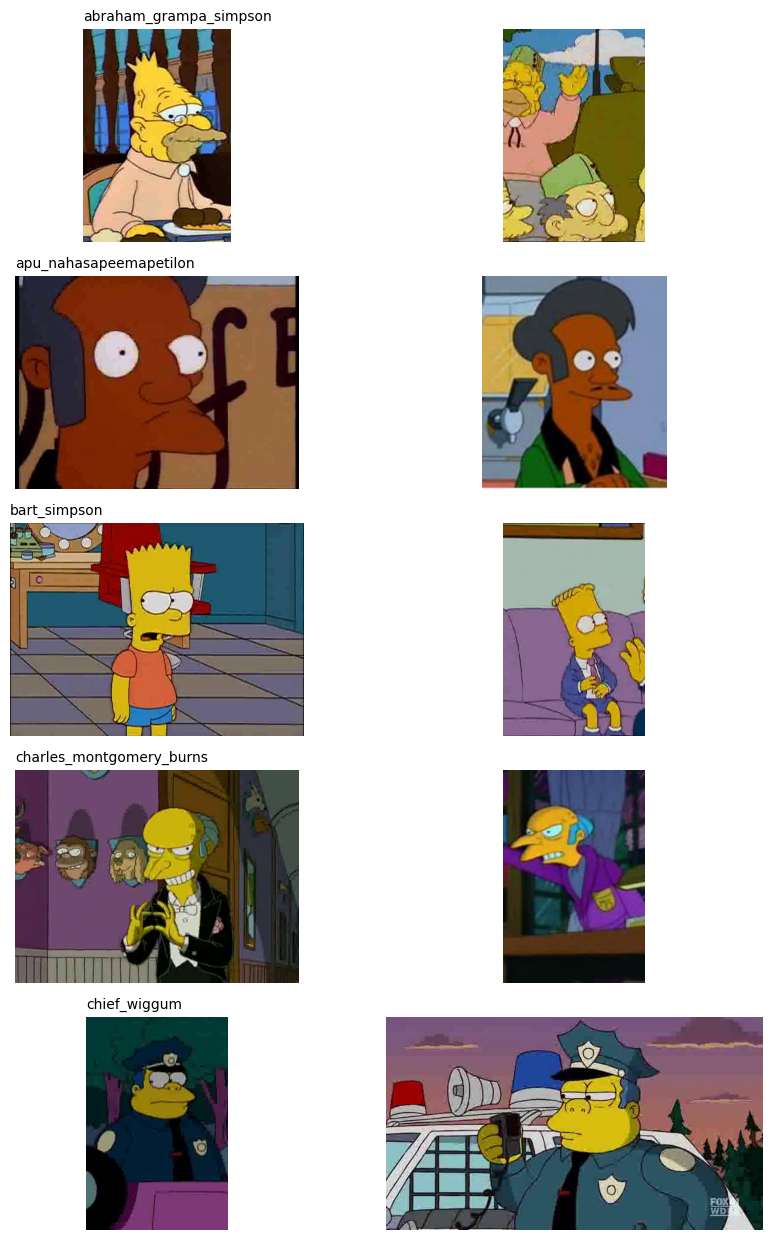

In [20]:
def plot_random_images(dataset_path, characters, num_characters=5) -> None:
    """
    Zeigt genau zwei zufällige Bilder von verschiedenen Charakteren an.

    Input:
        dataset_path: Pfad zum Dataset
        characters: Liste der Charaktere
        num_characters: Anzahl der Charaktere, die gezeigt werden sollen
    """
    num_images = 2  # Genau zwei Bilder pro Charakter
    fig, axes = plt.subplots(num_characters, num_images, figsize=(10, num_characters * 2.5))

    for i, character in enumerate(characters[:num_characters]):
        character_path = os.path.join(dataset_path, character)
        image_files = os.listdir(character_path)

        # Wähle zufällig zwei Bilder aus (oder weniger, falls nicht genug vorhanden)
        random_images = random.sample(image_files, min(num_images, len(image_files)))

        for j, img_name in enumerate(random_images):
            img_path = os.path.join(character_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")

        # Setze den Charakter-Namen als Titel für die linke Spalte
        axes[i, 0].set_title(character, fontsize=10, loc='left')

    plt.tight_layout()
    plt.show()

# Beispielaufruf für 5 Charaktere
plot_random_images(filtered_dataset_path, characters, num_characters=5)


## Daten einteilen

In [4]:
#########################################################################################################################################
# Liste der Klassen, die verwendet werden sollen
allowed_classes = [
    "sideshow_bob", "abraham_grampa_simpson", "chief_wiggum", "milhouse_van_houten",
    "charles_montgomery_burns", "principal_skinner", "krusty_the_clown", "marge_simpson",
    "bart_simpson", "lisa_simpson", "moe_szyslak", "ned_flanders", "homer_simpson"
]

# Ordner definieren
input_dir = "./filtered_simpsons_dataset"
output_dir = "./simpsons_dataset_split"

os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Speichert die ursprünglichen Bildanzahlen
original_distribution = {}

# Speichert die neuen Verteilungen
new_distribution = {"train": {}, "val": {}, "test": {}}

# Prozentsätze für die Splits
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

#Bilder für jede Klasse aufteilen
for class_name in allowed_classes:
    class_path = os.path.join(input_dir, class_name)
    
    # Falls Klasse nicht existiert, überspringen
    if not os.path.exists(class_path):
        print(f"⚠️ Warnung: Klasse '{class_name}' nicht gefunden!")
        continue

    # Liste der Bilder abrufen
    all_images = sorted(os.listdir(class_path))
    total_images = len(all_images)
    
    # Speichert die Originalverteilung
    original_distribution[class_name] = total_images

    # Berechnung der Split-Anzahlen basierend auf der Klassenverteilung
    train_size = int(np.round(total_images * train_ratio))
    val_size = int(np.round(total_images * val_ratio))
    test_size = total_images - train_size - val_size  # Restliche Bilder für Test

    # Bilder zufällig aufteilen (aber nach Originalverteilung)
    train_files, remaining_files = train_test_split(all_images, train_size=train_size, random_state=42, stratify=None)
    val_files, test_files = train_test_split(remaining_files, train_size=val_size, random_state=42, stratify=None)

    # Dateien in die jeweiligen Ordner verschieben
    for subset, subset_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        subset_class_dir = os.path.join(output_dir, subset, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)

        for file_name in subset_files:
            src_file = os.path.join(class_path, file_name)
            dst_file = os.path.join(subset_class_dir, file_name)
            shutil.copy(src_file, dst_file)

        # Speichert die neue Verteilung
        new_distribution[subset][class_name] = len(subset_files)

    print(f"✅ Verarbeitung abgeschlossen für '{class_name}' (Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)})")




✅ Verarbeitung abgeschlossen für 'sideshow_bob' (Train: 614, Val: 132, Test: 131)
✅ Verarbeitung abgeschlossen für 'abraham_grampa_simpson' (Train: 639, Val: 137, Test: 137)
✅ Verarbeitung abgeschlossen für 'chief_wiggum' (Train: 690, Val: 148, Test: 148)
✅ Verarbeitung abgeschlossen für 'milhouse_van_houten' (Train: 755, Val: 162, Test: 162)
✅ Verarbeitung abgeschlossen für 'charles_montgomery_burns' (Train: 835, Val: 179, Test: 179)
✅ Verarbeitung abgeschlossen für 'principal_skinner' (Train: 836, Val: 179, Test: 179)
✅ Verarbeitung abgeschlossen für 'krusty_the_clown' (Train: 844, Val: 181, Test: 181)
✅ Verarbeitung abgeschlossen für 'marge_simpson' (Train: 904, Val: 194, Test: 193)
✅ Verarbeitung abgeschlossen für 'bart_simpson' (Train: 939, Val: 201, Test: 202)
✅ Verarbeitung abgeschlossen für 'lisa_simpson' (Train: 948, Val: 203, Test: 203)
✅ Verarbeitung abgeschlossen für 'moe_szyslak' (Train: 1016, Val: 218, Test: 218)
✅ Verarbeitung abgeschlossen für 'ned_flanders' (Train: 101